In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

import numpy as np

## Define Functions

### Basic Signals

In [2]:
def unit_signal(t):
    return 1.0 if t >= 0 else 0.0

unit_signal_vectorize = np.vectorize(unit_signal)

In [3]:
def ramp_signal(t):
    return t * unit_signal(t)

ramp_signal_vectorize = np.vectorize(ramp_signal)

In [4]:
def rect_signal(t):
    return 1.0 if (t <= 0.5) & (t >= -0.5) else 0.0

rect_signal_vectorize = np.vectorize(rect_signal)

---

In [5]:
def t_range(a, b, size):
    return np.linspace(a, b, int(size * (b - a)))

In [6]:
def delta_signal(t, delta_pos):
    x = np.zeros_like(t)
    x_delta = np.zeros_like(t, dtype=bool)

    for shifted, coff in delta_pos:
        idx = np.argmin(np.abs(t - shifted))
        x[idx] = coff * 1.0 / (t[1] - t[0])
        x_delta[idx] = True
        
    return x, x_delta

---

### Visualization and Animation Function for Continuous Convolution

In [44]:
def visualize_continuous_convolution(
    x,
    h,
    t,
    x_delta = None,
    h_delta = None,
    h_left = 0,
    h_right = 0,
    x_label = "x",
    h_label = "h",
    y_label = "y",
    filename = "continuous_convolution_snapshot",
    dir_path = "../images/"
):
    """
    Create an image that visually demonstrates the continuous convolution of two signals x(t) and h(t).

    Parameters
    ----------
    x : np.ndarray
        Input signal x(t)
    h : np.ndarray
        Impulse response signal h(t)
    t : np.ndarray
        Time axis corresponding to x(t) and h(t)
    x_delta : np.ndarray of bool, optional
        Boolean array indicating if x(t) contains delta functions
    h_delta : np.ndarray of bool, optional
        Boolean array indicating if h(t) contains delta functions
    h_left : float, optional
        Value to use for h(t) when shifted beyond the left boundary
    h_right : float, optional
        Value to use for h(t) when shifted beyond the right boundary
    x_label : str
        Label for x(t)
    h_label : str
        Label for h(t)
    y_label : str
        Label for y(t)
    filename : str
        Output filename (without extension)
    dir_path : str
        Directory path to save the output PNG
    """

    if x_delta is None:
        x_delta = np.zeros_like(x, dtype=bool)
    if h_delta is None:
        h_delta = np.zeros_like(h, dtype=bool)
    
    # --- Precompute convolution ---
    taus = np.linspace(t[0] - (t[-1] - t[0]) / 2, t[-1] + (t[-1] - t[0]) / 2, 100)
    y_values = []
    for tau in taus:
        h_shifted = np.interp(tau - t, t, h, left=h_left, right=h_right)
        product = x * h_shifted
        y_val = np.trapezoid(product, t)  # integral approximation
        y_values.append(y_val)
    y_values = np.array(y_values)

    # --- Set up figure and subplots (3x2 grid) ---
    fig, axes = plt.subplots(3, 1, figsize=(8, 8))
    plt.tight_layout(pad=2.5)

    # --- Initialize plot elements ---
    line_x, = axes[0].plot([], [], lw=2)
    line_h, = axes[1].plot([], [], lw=2, color="orange")
    line_y, = axes[2].plot([], [], lw=2, color="purple")

    # --- Titles and layout ---
    titles = [
        fr"${x_label}(t)$",
        fr"${h_label}(t)$",
        fr"Convolution Output ${y_label}(t)$",
    ]
    
    # Compute y-limits automatically for each subplot
    # Add a small margin (5%)
    def auto_ylim(data, isdelta):
        delta_coff = np.where(isdelta, data, 0)
        delta_coff = delta_coff * (t[1] - t[0])
        
        if (isdelta is not None) and np.any(isdelta):
            data_clean = data[~isdelta]
        else:
            data_clean = data
        
        ymin, ymax = np.min(data_clean), np.max(data_clean)
        
        if (np.any(isdelta)):
            ymin = min(ymin, np.min(delta_coff))
            ymax = max(ymax, np.max(delta_coff))
        
        margin = 0.05 * (ymax - ymin if ymax != ymin else 1)
        return ymin - margin, ymax + margin
    
    # Top row: x(t)
    axes[0].set_ylim(auto_ylim(x, isdelta=x_delta))
    
    # Middle row: h(t)
    axes[1].set_ylim(auto_ylim(h, isdelta=h_delta))
    
    # Bottom left: convolution output y(tau)
    axes[2].set_ylim(auto_ylim(y_values, isdelta=np.zeros_like(y_values, dtype=bool)))

    # Set titles and x-limits
    axes_flat = axes.flatten()
    
    for ax, title in zip(axes_flat, titles):
        ax.set_title(title)
        ax.set_xlim(t[0], t[-1])
        ax.grid(True)

    # Bottom left subplot (convolution) x-axis corresponds to taus
    axes[2].set_xlim(taus[0], taus[-1])
    
    x_plot = np.where(~x_delta, x, 0)
    h_plot = np.where(~h_delta, h, 0)
    
    def plot_delta(ax, i, ti, coff, color="blue"):
        ax[i].arrow(ti, 0, 0, coff, head_width=0.1, head_length=0.1, width=0.02, fc=color, ec=color, length_includes_head=True)
        ax[i].plot(ti, 0, color=color, marker="o", markerfacecolor="white", markersize=5)

    # Draw delta function indicators for x(t)
    for ti, xi, is_delta in zip(t, x, x_delta):
        if is_delta:
            height = xi * (t[1] - t[0])
            plot_delta(axes, 0, ti, height, color="blue")

    # Draw delta function indicators for h(t)
    for ti, hi, is_delta in zip(t, h, h_delta):
        if is_delta:
            height = hi * (t[1] - t[0])
            plot_delta(axes, 1, ti, height, color="orange")

    # Update plots
    line_x.set_data(t, x_plot)
    line_h.set_data(t, h_plot)

    # Update convolution output
    line_y.set_data(taus, y_values)

    fig.subplots_adjust(top=0.88)
    fig.suptitle(fr"Convolution Visualization", fontsize=14)
    
    fig.savefig(f"{dir_path}{filename}.png", dpi=300)
    plt.close(fig)
    print(f"✅ Snapshot saved as {filename}.png")

In [45]:
def animate_continuous_convolution(
    x,
    h,
    t,
    x_delta = None,
    h_delta = None,
    h_left = 0,
    h_right = 0,
    x_label = "x",
    h_label = "h",
    y_label = "y",
    snapshot = False,
    filename = "continuous_convolution_animation",
    dir_path = "../images/",
):
    """
    Create an animated GIF that visually demonstrates the continuous convolution of two signals x(t) and h(t).

    Parameters
    ----------
    x : np.ndarray
        Input signal x(t)
    h : np.ndarray
        Impulse response signal h(t)
    t : np.ndarray
        Time axis corresponding to x(t) and h(t)
    x_delta : np.ndarray of bool, optional
        Boolean array indicating if x(t) contains delta functions
    h_delta : np.ndarray of bool, optional
        Boolean array indicating if h(t) contains delta functions
    x_label : str
        Label for x(t)
    h_label : str
        Label for h(t)
    y_label : str
        Label for y(t)
    snapshot : bool, optional
        If True, save the extra output as an image (PNG)
    filename : str
        Output filename (without extension)
    dir_path : str
        Directory path to save the output GIF
    """

    if x_delta is None:
        x_delta = np.zeros_like(x, dtype=bool)
    if h_delta is None:
        h_delta = np.zeros_like(h, dtype=bool)
    
    # --- Precompute convolution ---
    taus = np.linspace(t[0] - (t[-1] - t[0]) / 2, t[-1] + (t[-1] - t[0]) / 2, 100)
    y_values = []
    for tau in taus:
        h_shifted = np.interp(tau - t, t, h, left=h_left, right=h_right)
        product = x * h_shifted
        y_val = np.trapezoid(product, t)  # integral approximation
        y_values.append(y_val)
    y_values = np.array(y_values)

    # --- Set up figure and subplots (3x2 grid) ---
    fig, axes = plt.subplots(3, 2, figsize=(8, 8))
    plt.tight_layout(pad=2.5)

    # --- Initialize plot elements ---
    line_x_original, = axes[0, 0].plot([], [], lw=2)
    line_x, = axes[0, 1].plot([], [], lw=2)

    line_h_original, = axes[1, 0].plot([], [], lw=2, color="orange")
    line_h, = axes[1, 1].plot([], [], lw=2, color="orange")

    line_y, = axes[2, 0].plot([], [], lw=2, color="purple")
    dot_y, = axes[2, 0].plot([], [], "ro")

    line_prod, = axes[2, 1].plot([], [], lw=2, color="green")
    fill_prod = None

    # --- Titles and layout ---
    titles = [
        fr"Original ${x_label}(t)$", fr"${x_label}(t)$",
        fr"Original ${h_label}(t)$", fr"${h_label}(\tau - t)$",
        fr"Convolution Output ${y_label}(t)$", fr"${x_label}(t) \cdot {h_label}(\tau - t)$",
    ]
    # Compute y-limits automatically for each subplot
    # Add a small margin (5%)
    def auto_ylim(data, isdelta):
        delta_coff = np.where(isdelta, data, 0)
        delta_coff = delta_coff * (t[1] - t[0])
        
        if (isdelta is not None) and np.any(isdelta):
            data_clean = data[~isdelta]
        else:
            data_clean = data
        
        ymin, ymax = np.min(data_clean), np.max(data_clean)
        
        if (np.any(isdelta)):
            ymin = min(ymin, np.min(delta_coff))
            ymax = max(ymax, np.max(delta_coff))
        
        margin = 0.05 * (ymax - ymin if ymax != ymin else 1)
        return ymin - margin, ymax + margin
    
    # Top row: x(t)
    axes[0, 0].set_ylim(auto_ylim(x, isdelta=x_delta))
    axes[0, 1].set_ylim(auto_ylim(x, isdelta=x_delta))
    
    # Middle row: h(t) and h(tau - t) initial limits
    axes[1, 0].set_ylim(auto_ylim(h, isdelta=h_delta))
    axes[1, 1].set_ylim(auto_ylim(h, isdelta=h_delta))
    
    # Bottom left: convolution output y(tau)
    axes[2, 0].set_ylim(auto_ylim(y_values, isdelta=np.zeros_like(y_values, dtype=bool)))

    # Bottom right: product x(t) * h(tau - t)
    axes[2, 1].set_ylim(auto_ylim(y_values, isdelta=np.zeros_like(y_values, dtype=bool)))

    # Set titles and x-limits
    axes_flat = axes.flatten()
    
    for ax, title in zip(axes_flat, titles):
        ax.set_title(title)
        ax.set_xlim(t[0], t[-1])
        ax.grid(True)

    # Bottom left subplot (convolution) x-axis corresponds to taus
    axes[2, 0].set_xlim(taus[0], taus[-1])
    
    x_plot = np.where(~x_delta, x, 0)
    h_plot = np.where(~h_delta, h, 0)
    
    def plot_delta(ax, i, j, ti, coff, color="blue"):
        axes[i, j].arrow(ti, 0, 0, coff, head_width=0.1, head_length=0.1, width=0.02, fc=color, ec=color, length_includes_head=True)
        axes[i, j].plot(ti, 0, color=color, marker="o", markerfacecolor="white", markersize=5)

    # Draw delta function indicators for x(t)
    for ti, xi, is_delta in zip(t, x, x_delta):
        if is_delta:
            height = xi * (t[1] - t[0])
            plot_delta(axes, 0, 0, ti, height, color="blue")
            plot_delta(axes, 0, 1, ti, height, color="blue")

    # Draw delta function indicators for h(t)
    for ti, hi, is_delta in zip(t, h, h_delta):
        if is_delta:
            height = hi * (t[1] - t[0])
            plot_delta(axes, 1, 0, ti, height, color="orange")
            plot_delta(axes, 1, 1, ti, height, color="orange")

    
    # --- Animation initialization ---
    def init():
        for line in [line_x_original, line_x, line_h_original, line_h, line_prod, line_y, dot_y]:
            line.set_data([], [])
        return line_x_original, line_x, line_h_original, line_h, line_prod, line_y, dot_y

    # --- Animation frame update ---
    def animate(i):
        nonlocal fill_prod
        tau = taus[i]
        h_shifted = np.interp(tau - t, t, h_plot, left=h_left, right=h_right)
        product = x_plot * h_shifted
        y_val = y_values[i]

        # Remove old fill
        if fill_prod:
            fill_prod.remove()

        # Update plots
        line_x_original.set_data(t, x_plot)
        line_x.set_data(t, x_plot)
        line_h_original.set_data(t, h_plot)
        line_h.set_data(t, h_shifted)
        line_prod.set_data(t, product)
        fill_prod = axes[2, 1].fill_between(t, product, color="green", alpha=0.3)

        # Update convolution output
        line_y.set_data(taus[:i+1], y_values[:i+1])
        dot_y.set_data([tau], [y_val])
        
        fig.subplots_adjust(top=0.88)
        fig.suptitle(fr"Convolution Visualization — $\tau$ = {tau:.2f}", fontsize=14)
        return line_x_original, line_x, line_h_original, line_h, line_prod, line_y, dot_y

    # --- Create and save animation ---
    ani = animation.FuncAnimation(
        fig, animate, frames=len(taus), init_func=init, interval=100, blit=False
    )

    ani.save(f"{dir_path}{filename}.gif", writer="pillow", fps=15)
    plt.close(fig)
    print(f"✅ Animation saved as {filename}.gif")
    
    if snapshot:
        visualize_continuous_convolution(
            x, h, t,
            x_delta=x_delta, h_delta=h_delta,
            h_left=h_left, h_right=h_right,
            x_label=x_label, h_label=h_label, y_label=y_label,
            filename=filename + "_snapshot",
            dir_path=dir_path
        )

### Visualization and Animation Function for Discrete Convolution

In [58]:
def visualize_discrete_convolution(
    x,
    h,
    n,
    x_label="x",
    h_label="h",
    y_label="y",
    filename="discrete_convolution_snapshot",
    dir_path="../images/",
):
    """
    Create an image that visually demonstrates the discrete convolution of two signals x[n] and h[n].

    Parameters
    ----------
    x : np.ndarray
        Discrete input signal x[n]
    h : np.ndarray
        Discrete impulse response h[n]
    n : np.ndarray
        Sample indices corresponding to x[n] and h[n]
    x_label : str
        Label for x[n]
    h_label : str
        Label for h[n]
    y_label : str
        Label for y[n]
    filename : str
        Output filename (without extension)
    dir_path : str
        Directory path to save the output PNG
    """

    # --- Compute discrete convolution ---
    y = np.convolve(x, h)
    n_y = np.arange(2 * n[0], 2 * n[-1] + 1)

    # --- Figure setup ---
    fig, axes = plt.subplots(3, 1, figsize=(8, 8))
    plt.tight_layout(pad=2.5)

    # --- Initialize stems ---
    # (Each stem plot returns markerline, stemlines, baseline)
    def create_stem(ax, n, data, color="b"):
        markerline, stemlines, baseline = ax.stem(n, data, basefmt="k")
        plt.setp(markerline, color=color, markerfacecolor=color)
        plt.setp(stemlines, color=color)
        return markerline, stemlines, baseline

    # Original x[n], h[n]
    stem_x = create_stem(axes[0], n, x)
    stem_h = create_stem(axes[1], n, h, color="orange")

    # Result y[n]
    stem_y = create_stem(axes[2], n_y, y, color="purple")
    
    # Set X limits for all subplots
    axes[0].set_xlim(n[0] - 1, n[-1] + 1)
    axes[1].set_xlim(n[0] - 1, n[-1] + 1)
    axes[2].set_xlim(n_y[0] - 1, n_y[-1] + 1)
    
    # Set Y limits for all subplots
    axes[0].set_ylim(np.min(x) - 1, np.max(x) + 1)
    axes[1].set_ylim(np.min(h) - 1, np.max(h) + 1)
    axes[2].set_ylim(np.min(y) - 1, np.max(y) + 1)

    # --- Set labels, limits, and grids ---
    titles = [
        fr"${x_label}[n]$",
        fr"${h_label}[n]$",
        fr"Convolution Output ${y_label}[n]$",
    ]

    axes_flat = axes.flatten()
    for ax, title in zip(axes_flat, titles):
        ax.set_title(title)
        ax.grid(True)

    fig.subplots_adjust(top=0.88)
    fig.suptitle(fr"Discrete Convolution", fontsize=14)

    fig.savefig(f"{dir_path}{filename}.png", dpi=300)
    plt.close(fig)
    print(f"✅ Snapshot saved as {filename}.png")

In [62]:
def animate_discrete_convolution(
    x,
    h,
    n,
    x_label="x",
    h_label="h",
    y_label="y",
    snapshot=False,
    filename="discrete_convolution_animation",
    dir_path="../images/",
):
    """
    Create an animated GIF that visually demonstrates the discrete convolution of two signals x[n] and h[n].

    Parameters
    ----------
    x : np.ndarray
        Discrete input signal x[n]
    h : np.ndarray
        Discrete impulse response h[n]
    n : np.ndarray
        Sample indices corresponding to x[n] and h[n]
    x_label : str
        Label for x[n]
    h_label : str
        Label for h[n]
    y_label : str
        Label for y[n]
    snapshot : bool, optional
        If True, save the extra output as an image (PNG)
    filename : str
        Output filename (without extension)
    dir_path : str
        Directory path to save the output GIF
    """

    # --- Compute discrete convolution ---
    y = np.convolve(x, h)
    n_y = np.arange(2 * n[0], 2 * n[-1] + 1)

    # --- Figure setup ---
    fig, axes = plt.subplots(3, 2, figsize=(8, 8))
    plt.tight_layout(pad=2.5)

    # --- Initialize stems ---
    # (Each stem plot returns markerline, stemlines, baseline)
    def create_stem(ax, n, data, color="b"):
        markerline, stemlines, baseline = ax.stem(n, data, basefmt="k")
        plt.setp(markerline, color=color, markerfacecolor=color)
        plt.setp(stemlines, color=color)
        return markerline, stemlines, baseline

    # Original x[n], h[n]
    stem_x_orig = create_stem(axes[0, 0], n, x)
    stem_h_orig = create_stem(axes[1, 0], n, h, color="orange")

    # Dynamic plots (shifted and product)
    stem_x = create_stem(axes[0, 1], n, np.zeros_like(x))
    stem_h = create_stem(axes[1, 1], n, np.zeros_like(h), color="orange")
    stem_prod = create_stem(axes[2, 1], n, np.zeros_like(x), color="green")
    stem_y = create_stem(axes[2, 0], n_y, np.zeros_like(y), color="purple")
    dot_y, = axes[2, 0].plot([], [], "ro")
    
    # Set X limits for all subplots
    axes[0, 0].set_xlim(n[0] - 1, n[-1] + 1)
    axes[0, 1].set_xlim(n[0] - 1, n[-1] + 1)
    axes[1, 0].set_xlim(n[0] - 1, n[-1] + 1)
    axes[1, 1].set_xlim(n[0] - 1, n[-1] + 1)
    axes[2, 0].set_xlim(n_y[0] - 1, n_y[-1] + 1)
    axes[2, 1].set_xlim(n[0] - 1, n[-1] + 1)
    
    # Set y limits for all subplots
    axes[0, 0].set_ylim(np.min(x) - 1, np.max(x) + 1)
    axes[0, 1].set_ylim(np.min(x) - 1, np.max(x) + 1)
    axes[1, 0].set_ylim(np.min(h) - 1, np.max(h) + 1)
    axes[1, 1].set_ylim(np.min(h) - 1, np.max(h) + 1)
    axes[2, 0].set_ylim(np.min(y) - 1, np.max(y) + 1)
    
    # Calculate product y-limits
    combination = np.array([xi * hi for xi in x for hi in h])
    prod_min, prod_max = np.min(combination), np.max(combination)
    axes[2, 1].set_ylim(prod_min - 1, prod_max + 1)

    # --- Set labels, limits, and grids ---
    titles = [
        fr"Original ${x_label}[n]$", fr"${x_label}[n]$",
        fr"Original ${h_label}[n]$", fr"${h_label}[n_0 - n]$",
        fr"Convolution Output ${y_label}[n]$", fr"${x_label}[n] \cdot {h_label}[n_0 - n]$",
    ]

    axes_flat = axes.flatten()
    for ax, title in zip(axes_flat, titles):
        ax.set_title(title)
        ax.grid(True)

    # --- Animation functions ---
    def init():
        nonlocal stem_x, stem_h, stem_prod, stem_y
        
        for stem_group in [stem_x, stem_h, stem_prod, stem_y]:
            for obj in stem_group:
                obj.set_visible(False)
        dot_y.set_data([], [])
        return []

    def animate(i):
        n0 = n_y[i]

        # Shift and flip h
        h_shifted = np.zeros_like(n, dtype=float)
        for k in range(len(n)):
            idx = np.where(n == (n0 - n[k]))[0]
            if len(idx) > 0:
                h_shifted[k] = h[idx[0]]

        # Compute pointwise product and convolution sum
        prod = x * h_shifted
        y_val = np.sum(prod)

        # Update stem plots
        nonlocal stem_x, stem_h, stem_prod, stem_y
        
        for stem_group in [stem_x, stem_h, stem_prod]:
            for obj in stem_group:
                obj.remove()
        stem_x = create_stem(axes[0, 1], n, x, color="b")
        stem_h = create_stem(axes[1, 1], n, h_shifted, color="orange")
        stem_prod = create_stem(axes[2, 1], n, prod, color="g")

        # Update convolution output
        for obj in stem_y:
            obj.remove()
        stem_y = create_stem(axes[2, 0], n_y[:i+1], y[:i+1], color="purple")

        dot_y.set_data([n0], [y_val])
        
        fig.subplots_adjust(top=0.88)
        fig.suptitle(fr"Discrete Convolution — $n_0 = {n0}$", fontsize=14)
        return list(stem_x + stem_h + stem_prod + stem_y) + [dot_y]

    # --- Create and save animation ---
    ani = animation.FuncAnimation(
        fig, animate, frames=len(n_y), init_func=init, interval=200, blit=False
    )
    ani.save(f"{dir_path}{filename}.gif", writer="pillow", fps=5)
    plt.close(fig)
    print(f"✅ Animation saved as {filename}.gif")
    
    if snapshot:
        visualize_discrete_convolution(
            x, h, n,
            x_label=x_label, h_label=h_label, y_label=y_label,
            filename=filename + "_snapshot",
            dir_path=dir_path
        )

## Problem 1
Evaluate the convolution of the following signals
1. $ \textrm{rect} \left( \frac{t-a}{a} \right) * \delta (t-b) $

2. $ \textrm{rect} \left( \frac{t}{a} \right) * \textrm{rect} \left( \frac{t}{a} \right) $

3. $ t[u(t)-u(t-1)]*u(t) $

In [9]:
# Problem 1.1.

# Parameters
a = 2.0
b = 1.0
t = t_range(-1, 5, 1000)
delta_pos = [(b, 1)]

# Define signals
x = rect_signal_vectorize((t - a) / a)
h, h_delta = delta_signal(t, delta_pos)

# Label
x_label = "rect(\\frac{t - a}{a}) \\; @ \\; t = \\,"
h_label = "\\delta(t - b) \\; @ \\; t = \\,"

# Convolution result:
animate_continuous_convolution(x, h, t, h_delta=h_delta, x_label=x_label, h_label=h_label, snapshot=True, filename="problem_1_1")

✅ Animation saved as problem_1_1.gif
✅ Image saved as problem_1_1_snapshot.png


In [10]:
# Problem 1.2.

# Parameters
a = 2.0
t = t_range(-3, 3, 1000)

# Define signals
rect_signal = rect_signal_vectorize(t / a)

# Label
rect_label = "rect(\\frac{t}{a}) \\; @ \\; t = \\,"

# Convolution result:
animate_continuous_convolution(rect_signal, rect_signal, t, x_label=rect_label, y_label=rect_label, snapshot=True, filename="problem_1_2")

✅ Animation saved as problem_1_2.gif
✅ Image saved as problem_1_2_snapshot.png


In [11]:
# Problem 1.3.

# Parameters
t = t_range(-1, 2, 1000)

# Define signals
x = t * (unit_signal_vectorize(t) - unit_signal_vectorize(t - 1))
h = unit_signal_vectorize(t)

# Label
x_label = "t \\, [u(t) - u(t-1)] \\; @ \\; t = \\,"
h_label = "u"

# Convolution result:
animate_continuous_convolution(x, h, t, h_right=1, x_label=x_label, h_label=h_label, snapshot=True, filename="problem_1_3")

✅ Animation saved as problem_1_3.gif
✅ Image saved as problem_1_3_snapshot.png


## Problem 2
Determine the convolution $ y(t) = h(t) * x(t) $ using Graphical Interpretation of the pairs of the signals shown

1. <a href="https://imgbb.com/"><img src="https://i.ibb.co/YDVdjT1/ii-1.jpg" alt="ii-1" border="0"></a>

2. <a href="https://imgbb.com/"><img src="https://i.ibb.co/102mFqd/ii-2.jpg" alt="ii-2" border="0"></a>

3. <a href="https://imgbb.com/"><img src="https://i.ibb.co/vDsDW2z/ii-3.jpg" alt="ii-3" border="0"></a>

---

**[optional]**

4. <a href="https://imgbb.com/"><img src="https://i.ibb.co/fdND0Dv/ii-4.jpg" alt="ii-4" border="0"></a>

In [12]:
# Problem 2.1.

# Parameters
t = t_range(-2, 2, 1000)

# Define signals
x = rect_signal_vectorize(t / 2)
h = x * (abs(t) / t)

# Convolution result:
animate_continuous_convolution(x, h, t, snapshot=True, filename="problem_2_1")

✅ Animation saved as problem_2_1.gif
✅ Image saved as problem_2_1_snapshot.png


In [13]:
# Problem 2.2.

# Parameters
t = t_range(-2, 2, 1000)

# Define signals
x = np.where((t >= 0) & (t <= 1), t, 0)
h = rect_signal_vectorize(t / 2)

# Convolution result:
animate_continuous_convolution(x, h, t, snapshot=True, filename="problem_2_2")

✅ Animation saved as problem_2_2.gif
✅ Image saved as problem_2_2_snapshot.png


In [14]:
# Problem 2.3.

# Parameters
t = t_range(-2, 3, 1000)
delta_pos = [(2, 1)]

# Define signals
x, x_delta = delta_signal(t, delta_pos)
x += 2 * rect_signal_vectorize(t + 0.5)

h = rect_signal_vectorize(t / 2)

# Convolution result:
animate_continuous_convolution(x, h, t, x_delta=x_delta, snapshot=True, filename="problem_2_3")

✅ Animation saved as problem_2_3.gif
✅ Image saved as problem_2_3_snapshot.png


In [15]:
# Problem 2.4.

# Parameters
t = t_range(-2, 2, 1000)
delta_pos = [(-1, 1), (1, -1)]

# Define signals
x = np.piecewise(t, [ (t >= -1) & (t < 0), (t >= 0) & (t < 1) ], [lambda t: -t, lambda t: t, 0])
h, h_delta = delta_signal(t, delta_pos)

# Convolution result:
animate_continuous_convolution(x, h, t, h_delta=h_delta, snapshot=True, filename="problem_2_4")

✅ Animation saved as problem_2_4.gif
✅ Image saved as problem_2_4_snapshot.png


## Problem 3
Let $ f(t) $ and $ g(t) $ be given as follows:

---

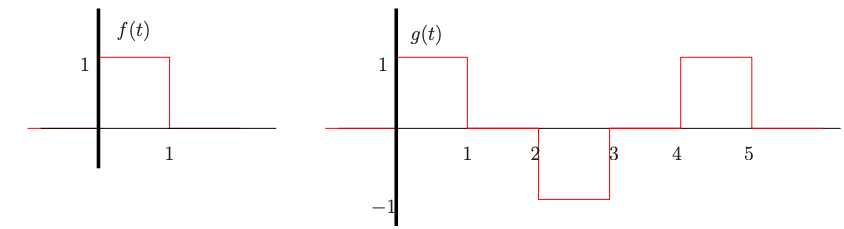

1. Sketch the function : $ x(t) = f(t) * g(t) $

2. Show that if $ a(t) = b(t) * c(t) $, then $ (Mb(t)) * c(t) = Ma(t) $, for any real number M (hint: use the convolution integral formula)

In [19]:
# Problem 3.1.

# Parameters
t = t_range(-1, 6, 1000)

# Define signals
x = rect_signal_vectorize(t - 0.5)
h = rect_signal_vectorize(t - 0.5) - rect_signal_vectorize(t - 2.5) + rect_signal_vectorize(t - 4.5)

# Label
x_label = "f"
h_label = "g"

# Convolution result:
animate_continuous_convolution(x, h, t, x_label=x_label, h_label=h_label, snapshot=True, filename="problem_3_1")

✅ Animation saved as problem_3_1.gif
✅ Image saved as problem_3_1_snapshot.png


## Problem 4
Find the convolution $ y[n] = h[n] * x[n] $ of the following signals:

1. $ x[n] = \begin{cases} -1 , -5 \leq n \leq -1 \\ 1 , 0 \leq n \leq 4 \end{cases},\, h[n] = 2u[n] $

2. $ x[n] = u[n],\, h[n] = 1 \; ; 0 \leq n \leq 9 $

3. $ x[n] = \left( \frac{1}{2} \right)^n u[n],\, h[n] = \delta[n] +\delta[n-1] +  \left( \frac{1}{3} \right)^n u[n] $

4. $ x[n] = \left( \frac{1}{3} \right)^n u[n],\, h[n] = \delta[n] + \left( \frac{1}{2} \right)^n u[n] $

## Problem 5
Find the convolution $ y[n] = h[n] * x[n] $ of the following signals
1. $ x[n] = \left\{ 1, -\frac{1}{2}, \frac{1}{4}, -\frac{1}{8}, \frac{1}{16} \right \},\, h[n] = \left\{ 1, -1, 1, -1 \right\} $

2. $ x[n] = \left\{ 1, 2, 3, 0, -1, \right \},\, h[n] = \left\{ 2, -1, 3, 1, -2 \right\} $

3. $ x[n] = \left\{ 3, \frac{1}{2}, -\frac{1}{4}, 1, 4 \right \},\, h[n] = \left\{ 2, -1, \frac{1}{2}, -\frac{1}{2} \right\} $

4. $ x[n] = \left\{ -1, \frac{1}{2}, \frac{3}{4}, -\frac{1}{5}, 1 \right \},\, h[n] = \left\{ 1, 1, 1, 1, 1 \right\} $

## Problem 6





### Problem 6.1 : Convolution - 1D
The following code creates a gaussian pulse and its self convolutions. Study and apply the convolution between signal e and another signal e with noise (e_noise) and write the report to analyze the results.

In [ ]:
from scipy import signal

t = np.linspace(-1, 1, 2 * 100, endpoint=False)
i, q, e = signal.gausspulse(t, fc=5, retquad=True, retenv=True)
plt.plot(t, e, '--',label = 'orignal signal')
plt.legend(loc='upper right')
plt.show()


conv_e = np.convolve(e,e,'same')
plt.plot(t, e, '--',label = 'orignal signal')
plt.plot(t, conv_e, '--',label = 'self conv signal')
plt.legend(loc='upper right')
plt.show()

e_noise = e + np.random.randn(len(e))*2.5
conv_e_noise = np.convolve(e,e_noise,'same')

# TODO : Apply the convolution between signal e and another signal e with noise (e_noise) and check the results


### Problem 6.2

From the self convolution below, when increasing the number of self convolution (now is 8), what is noticeable from the final shape resulted from the convolution?

(HINT 01: Central limit theorem)

(HINT 02: What is Probability Density Function (PDF) of $ z $ if $ z = x + y \; ? $ )

In [ ]:
from scipy.stats import uniform

x = np.linspace(-5,5, 1000)
plt.plot(x, uniform.pdf(x),
       'r-', lw=5, alpha=0.6, label='uniform pdf')

plt.show()


x = np.linspace(-15,15, 10000)
pdf_1 = uniform.pdf(x)
pdf_2 = uniform.pdf(x)

for i in range(8):
    pdf_2 = np.convolve(pdf_2,pdf_1, 'same')

pdf_2 = pdf_2/np.max(pdf_2)
plt.plot(x, pdf_2,'r-', lw=5, alpha=0.6, label='conv uniform')

## Problem 7
### 2D (image) signal convolution:
The following code show the 2D signal (image $ f(x, y) $) and a kernel (diag_line). Study the convolution of the kernel and the image. Apply with `"circuits.png"` image and analyze the results.

**TODO** : Apply diag_line to the `"circuits.png"` image and analyse the results

In [ ]:
!wget https://drive.google.com/uc?id=1hQ8uKocLTjaKmrJm-O4BfZxvLLM1Cfa- -O circuits.png
!wget https://drive.google.com/uc?id=1WoISJ6-FECt-gt6Ovjlfmz89oGH812GM -O hamtaro0.jpg

In [ ]:
import cv2

image_path = 'hamtaro0.jpg'

diag_line = np.array([[ 2, -1, -1],
                    [-1, 2, -1],
                    [-1, -1, 2]])

ham = cv2.imread(image_path,0)
plt.figure(figsize=(10,10))
plt.imshow(ham, cmap='gray')
plt.show()
grad = signal.convolve2d(ham,diag_line,boundary='symm',mode='same')
plt.figure(figsize=(10,10))
plt.imshow(grad, cmap='gray')
plt.show()

# TODO : Apply diag_line to the "circuits.png image" and analyse the results


## Problem 8
Are the following systems linear or time invariant?
1. $x(t)$ -> **System(a)** -> $7x(t-1)$

2. $x(t)$ -> **System(b)** -> $cos(2x(t))$

3. $x(t)$ -> **System(c)** -> $t$

4. $x(t)$ -> **System(d)** -> $x(t)+t$